# **Fairness implementation for hiring system**

A company is looking to hire a new employee. They use a machine learning algorithm to select the top candidates. The candidates are assigned either **0** if they're not selected or **1** if they are.  

We evaluate two types of metrics:  
### **Equality of Outcome**  
These metrics measure the distribution of positive outcomes with respect to the protected characteristic. We focus on this when we want our model to predict an equal proportion of positive outcomes for the protected group compared to the rest of the population. We will estimate the following metrics:  

- **Statistical Parity**  
- **Disparate Impact**  

### **Equality of Opportunity**  
These metrics measure the distribution of model errors with respect to the protected characteristic. They are useful when Statistical Parity is not an appropriate goal. For example, if there are legitimate reasons for a protected group to have a different rate of positive outcomes compared to the rest of the population, but we still want to ensure the model makes the same volume and types of errors for both groups. We will estimate the following metric:  

- **Equal Opportunity Difference**  


In [82]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1.Data preparation

In [113]:
# Function to split a DataFrame into features (X), labels (y), and demographic data (dem)
def split_data_from_df(data):
    """
    Splits a DataFrame into features (X), labels (y), and demographic data (dem).
    """
    filter_col = ['nationality', 'gender'] 
    features = data.drop(columns=["Id", "decision"]+filter_col).columns
    y = data['decision'].values  # Extract labels
    X = data[features].values  # Extract features
    dem = data[filter_col].copy()  # Extract demographics
    return X, y, dem  # Return features, labels, demographics

# Function to resample a DataFrame to balance categories by oversampling based on a combined category-label identifier
def resample_equal(df, cat):
    """
    Resamples the DataFrame to balance categories by oversampling
    based on a combined category-label identifier.
    """
    df['uid'] = df[cat] + df['Label'].astype(str)  # Create unique identifier combining category and label
    enc = LabelEncoder()  # Initialize label encoder
    df['uid'] = enc.fit_transform(df['uid'])  # Encode the combined identifier
    res = imblearn.over_sampling.RandomOverSampler(random_state=6)  # Initialize oversampler
    df_res, euid = res.fit_resample(df, df['uid'].values)  # Apply oversampling
    df_res = pd.DataFrame(df_res, columns=df.columns)  # Convert to DataFrame
    df_res = df_res.sample(frac=1).reset_index(drop=True)  # Shuffle rows
    df_res['Label'] = df_res['Label'].astype(float)  # Convert label to float
    return df_res  # Return resampled DataFrame

# Function to calculate and return model accuracy and fairness metrics for two groups
def get_metrics(group_a, group_b, y_pred, y_true):
    """
    Returns a DataFrame of model accuracy and fairness metrics for two groups.
    """
    metrics = [['Model Accuracy', round(accuracy_score(y_true, y_pred), 2), 1]]  # Calculate accuracy
    metrics += [['Black vs. White Disparate Impact', round(disparate_impact(group_a, group_b, y_pred), 2), 1]]  # Calculate disparate impact
    metrics += [['Black vs. White Statistical Parity', round(statistical_parity(group_a, group_b, y_pred), 2), 0]]  # Calculate statistical parity
    metrics += [['Black vs. White Average Odds Difference', round(average_odds_diff(group_a, group_b, y_pred, y_true), 2), 0]]  # Calculate average odds difference
    return pd.DataFrame(metrics, columns=['Metric', 'Value', 'Reference'])  # Return metrics as DataFrame

# Function to plot a confusion matrix with annotations
def plot_cm(y_true, y_pred, labels=[1, 0], display_labels=[1, 0], ax=None):
    """
    Plots a single confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)  # Compute confusion matrix

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))  # Create new figure if no axis is provided

    # Create heatmap for confusion matrix
    sns.heatmap(
        cm, annot=True, fmt="g", cmap="viridis", cbar=False,
        xticklabels=display_labels, yticklabels=display_labels,
        square=True, linewidths=2, linecolor="black", ax=ax, annot_kws={"size": 14}
    )

    # Label and format axes
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
    ax.set_ylabel("True Label", fontsize=12, fontweight="bold")
    ax.set_xticklabels(display_labels, fontsize=11)
    ax.set_yticklabels(display_labels, fontsize=11)

    return cm  # Return confusion matrix

# Function to plot confusion matrices for different groups in a dataset
def plot_confusion_matrices(groups, data_test, category, y_test, y_pred_test):
    """
    Plots confusion matrices for each group in a given category.
    """
    num_groups = len(groups) + 1  # Number of groups to display
    fig, axes = plt.subplots(1, num_groups, figsize=(5 * num_groups, 4))  # Create subplot grid

    # Plot confusion matrix for overall data
    cm = plot_cm(y_test, y_pred_test, ax=axes[0])
    axes[0].set_title("All", fontsize=14, fontweight="bold")

    # Plot confusion matrices for each group in the dataset
    cm_dict = {"All": cm}  # Store overall confusion matrix
    for i, group in enumerate(groups):
        ax = axes[i + 1]  # Get axis for group
        subset = data_test[data_test[category] == group]  # Filter data for group
        cm = plot_cm(subset["Label"], subset["Pred"], ax=ax)  # Plot confusion matrix for group
        cm_dict[group] = cm  # Store confusion matrix for group
        ax.set_title(group, fontsize=14, fontweight="bold")

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plot
    return cm_dict  # Return dictionary of confusion matrices for each group

# Function to calculate True Positive Rate (TPR) from confusion matrices
def calculate_tpr(cms):
    """
    Calculates True Positive Rates (TPR) for each group,
    given a set of confusion matrices.
    """
    tprs = {g: cm[0, 0] / cm[0, :].sum() for g, cm in cms.items()}  # Calculate TPR
    return tprs  # Return dictionary of TPRs


In [109]:
data = pd.read_csv('data/recruitmentdataset-2022.csv')
boolean_features = ["ind-debateclub", "ind-programming_exp", "ind-international_exp", "ind-entrepeneur_exp", "ind-exact_study", "decision"]
categorical_features = ["sport", "ind-degree", "company"]
data

,Id,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,x8011e,female,24,German,Swimming,70,False,False,False,False,1,True,phd,A,True
1,x6077a,male,26,German,Golf,67,False,True,False,False,2,True,bachelor,A,False
2,x6006e,female,23,Dutch,Running,67,False,True,True,False,0,True,master,A,False
3,x2173b,male,24,Dutch,Cricket,70,False,True,False,False,1,True,master,A,True
4,x6241a,female,26,German,Golf,59,False,False,False,False,1,False,master,A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,x7640e,female,28,Dutch,Running,63,False,False,False,False,0,False,master,D,False
3996,x3310f,female,27,Dutch,Tennis,62,False,False,False,True,2,True,bachelor,D,False
3997,x1202g,male,24,Belgian,Rugby,60,True,False,False,True,2,False,bachelor,D,False
3998,x1263d,female,22,Dutch,Tennis,66,False,True,False,False,1,True,bachelor,D,False


In [110]:
data["nationality"].value_counts()

nationality
Dutch      3167
Belgian     434
German      399
Name: count, dtype: int64

In [111]:
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(data[categorical_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))
data = pd.concat([encoded_df, data.drop(columns=categorical_features)], axis=1)
data[boolean_features] = data[boolean_features].astype(int)
data

,sport_Chess,sport_Cricket,sport_Football,sport_Golf,sport_Rugby,sport_Running,sport_Swimming,sport_Tennis,ind-degree_bachelor,ind-degree_master,...,age,nationality,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,decision
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,24,German,70,0,0,0,0,1,1,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,26,German,67,0,1,0,0,2,1,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,23,Dutch,67,0,1,1,0,0,1,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,24,Dutch,70,0,1,0,0,1,1,1
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,26,German,59,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,28,Dutch,63,0,0,0,0,0,0,0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,27,Dutch,62,0,0,0,1,2,1,0
3997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,24,Belgian,60,1,0,0,1,2,0,0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,22,Dutch,66,0,1,0,0,1,1,0


# 2.Train the model

In [112]:
# Split the data into training and testing sets (70% training, 30% testing)
data_train, data_test = train_test_split(data, test_size=0.3, random_state=4)

# Get the feature matrix (X), target labels (y), and demographic data for both sets
X_train, y_train, dem_train = split_data_from_df(data_train)
X_test, y_test, dem_test = split_data_from_df(data_test)

# Define the model (RidgeClassifier) and train it on the training data
model = RidgeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate and print the accuracy of the model on the test set
acc = accuracy_score(y_test, y_pred_test)
print("Accuracy = %.2f" % acc)

# Add the model's predictions to the data_test DataFrame for easier analysis
data_test = data_test.copy()
data_test['Pred'] = y_pred_test

Accuracy = 0.73


### **3. Evaluate Performance Metrics for Each Demographic Group**

#### **3.1 Accuracy**

In [103]:
print("---- ACCURACY BY GENDER ----")

# Calculate accuracy for each gender group
dem_test = dem_test.reset_index(drop=True)
for group in dem_test['gender'].unique():
    # Get the indices of the samples belonging to the current group
    idx_group = dem_test[dem_test['gender'] == group].index

    # Calculate the accuracy for the current group
    acc = accuracy_score(y_test[idx_group], y_pred_test[idx_group])
    print(group, 'Accuracy = %.3f' % acc)

print()

print("---- ACCURACY BY nationality ----")
# Calculate accuracy for each ethnicity group
for group in dem_test['nationality'].unique():
    # Get the indices of the samples belonging to the current group
    idx_group = dem_test[dem_test['nationality'] == group].index

    # Calculate the accuracy for the current group
    acc = accuracy_score(y_test[idx_group], y_pred_test[idx_group])
    print(group, 'Accuracy = %.3f' % acc)


---- ACCURACY BY GENDER ----
female Accuracy = 0.764
male Accuracy = 0.709
other Accuracy = 0.667

---- ACCURACY BY nationality ----
Dutch Accuracy = 0.732
Belgian Accuracy = 0.754
German Accuracy = 0.717


#### **3.2 Success Rate**

The success rate $ SR $ for a given group is calculated as the proportion of candidates in that group who received a prediction of **1** from the model. Mathematically, it can be expressed as:

$$
SR_{g} = \frac{\sum_{i=1}^{n} \mathbb{1}(\hat{y_i} = 1)}{n}
$$

where:  
- $n$ is the total number of candidates in group $g$ .  
- $\hat{y_i}$ represents the model's prediction for the $i$-th candidate.  
- $\mathbb{1}(\hat{y}_i = 1) $ is an indicator function that equals 1 if the model predicts 1 and 0 otherwise.  



In [104]:
# Calculate the success rate for each gender group
sr_male = y_pred_test[data_test['gender'] == 'male'].mean()
sr_female = y_pred_test[data_test['gender'] == 'female'].mean()
pred_g_mean = data_test.groupby('gender')['Pred'].mean()

print("---- SUCCESS RATE BY GENDER----")
for g in pred_g_mean.index:
    print(g, '= %.3f' % pred_g_mean[g])
print()

# Calculate the success rate for each ethnicity group
sr_dutch = y_pred_test[data_test['nationality'] == 'Dutch'].mean()
sr_belgian = y_pred_test[data_test['nationality'] == 'Belgian'].mean()
sr_german = y_pred_test[data_test['nationality'] == 'German'].mean()
pred_e_mean = data_test.groupby('nationality')['Pred'].mean()


print("---- SUCCESS RATE BY NATIONALITY----")
for e in pred_e_mean.index:
    print(e, '= %.3f' % pred_e_mean[e])

---- SUCCESS RATE BY GENDER----
female = 0.137
male = 0.234
other = 0.238

---- SUCCESS RATE BY ETHNICITY----
Belgian = 0.224
Dutch = 0.183
German = 0.212


### **4. Evaluate Equality of Outcome Metrics**

#### **4.1 Statistical Parity**
***Statistical Parity***. The difference between the success rate of the minority group and the majority group:
$$
SP = SR_{a} - SR_{b}
$$
where:  
- $SR_g$ is the success rate for group $g$, defined as the proportion of candidates that received a prediction of 1 from the model.  

A value between $-0.1$ and $0.1$ is generally considered fair, with stricter bounds of $-0.05$ and $0.05$ used in some contexts.

---- STATISTICAL PARITY ----
Female vs. Male = -0.03
Black vs. White = -0.09
Asian vs. White = -0.07
Hispanic vs. White = -0.03



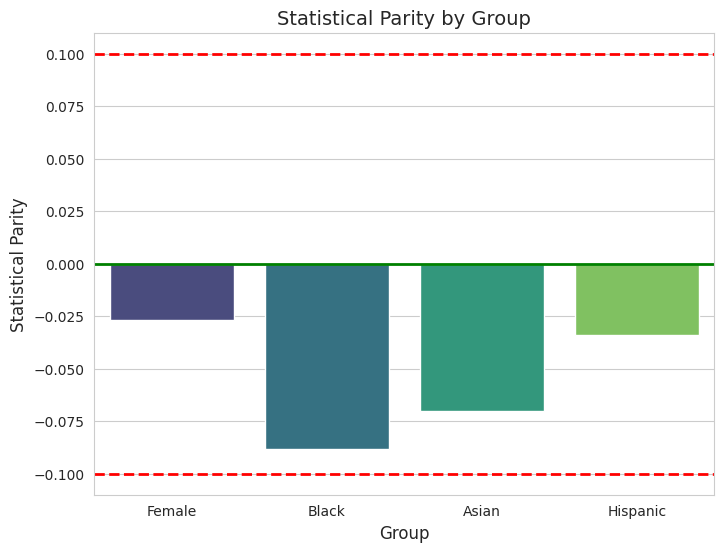

In [ ]:
# STATISTICAL PARITY
# Calculate the difference in success rate between different gender and nationality groups
sp_fm = sr_female - sr_male  # Female vs. Male
sp_bw = sr_black - sr_white  # Black vs. White
sp_aw = sr_asian - sr_white  # Asian vs. White
sp_hw = sr_hispanic - sr_white  # Hispanic vs. White

# Print Statistical Parity values
print('---- STATISTICAL PARITY ----')
print('Female vs. Male = %.2f' % sp_fm)
print('Black vs. White = %.2f' % sp_bw)
print('Asian vs. White = %.2f' % sp_aw)
print('Hispanic vs. White = %.2f' % sp_hw)
print()


# Plot Statistical Parity
df = pd.DataFrame(
    zip(['Female', 'Black', 'Asian', 'Hispanic'], [sp_fm, sp_bw, sp_aw, sp_hw]),
    columns=['Group', 'Statistical Parity (SP)']
)


sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Group', y='Statistical Parity (SP)', data=df, palette="viridis", hue='Group', legend=False)
plt.axhline(y=-0.1, linewidth=2, color='r', linestyle="--")  # Threshold for fairness (lower bound)
plt.axhline(y=0.1, linewidth=2, color='r', linestyle="--")   # Threshold for fairness (upper bound)
plt.axhline(y=0, linewidth=2, color='g', linestyle="-")      # Line representing 0 (no disparity)
plt.title("Statistical Parity by Group", fontsize=14)
plt.xlabel("Group", fontsize=12)
plt.ylabel("Statistical Parity", fontsize=12)
plt.show()



#### **4.2 Disparate Impact**
***Disparate Impact***. The ratio of the success rate of the minority group:
$$
DI = \frac{SR_{a}}{SR_{b}}
$$

Fairness is often considered achieved for values between $0.8$ and $1.2$.

---- DISPARATE IMPACT ----
Female vs. Male = 0.92
Black vs. White = 0.75
Asian vs. White = 0.80
Hispanic vs. White = 0.90


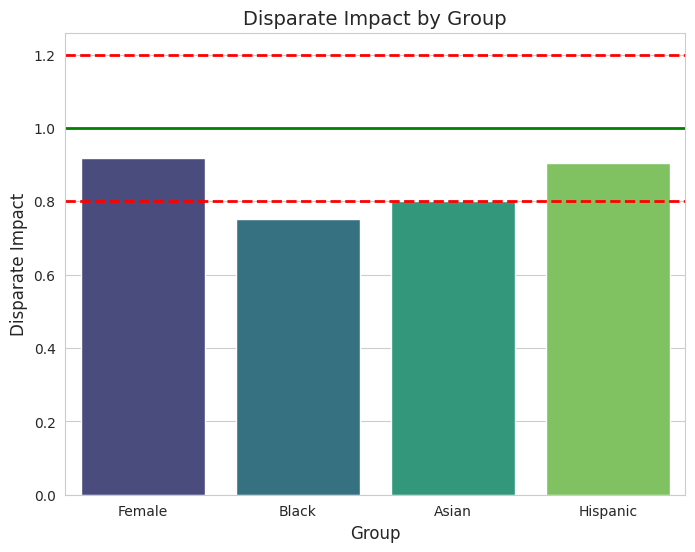

In [ ]:
# DISPARATE IMPACT
# Calculate the ratio of success rates between different gender and ethnicity groups
di_fm = sr_female / sr_male  # Female vs. Male
di_bw = sr_black / sr_white  # Black vs. White
di_aw = sr_asian / sr_white  # Asian vs. White
di_hw = sr_hispanic / sr_white  # Hispanic vs. White

# Print Disparate Impact values
print('---- DISPARATE IMPACT ----')
print('Female vs. Male = %.2f' % di_fm)
print('Black vs. White = %.2f' % di_bw)
print('Asian vs. White = %.2f' % di_aw)
print('Hispanic vs. White = %.2f' % di_hw)

# Prepare Data for Plotting
# Create a DataFrame with the calculated Statistical Parity and Disparate Impact values for each group
df = pd.DataFrame(
    zip(['Female', 'Black', 'Asian', 'Hispanic'], [di_fm, di_bw, di_aw, di_hw]),
    columns=['Group', 'Disparate Impact (DI)']
)

# Plot Disparate Impact
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Group', y='Disparate Impact (DI)', data=df, palette="viridis", hue='Group', legend=False)
plt.axhline(y=0.8, linewidth=2, color='r', linestyle="--")   # Lower threshold for fairness
plt.axhline(y=1.2, linewidth=2, color='r', linestyle="--")   # Upper threshold for fairness
plt.axhline(y=1, linewidth=2, color='g', linestyle="-")      # Line representing 1 (ideal fairness)
plt.title("Disparate Impact by Group", fontsize=14)
plt.xlabel("Group", fontsize=12)
plt.ylabel("Disparate Impact", fontsize=12)
plt.show()


### **5. Evaluate Equality of Opporutinity Metric**

### **5.1 Plot Confusion Matrices**

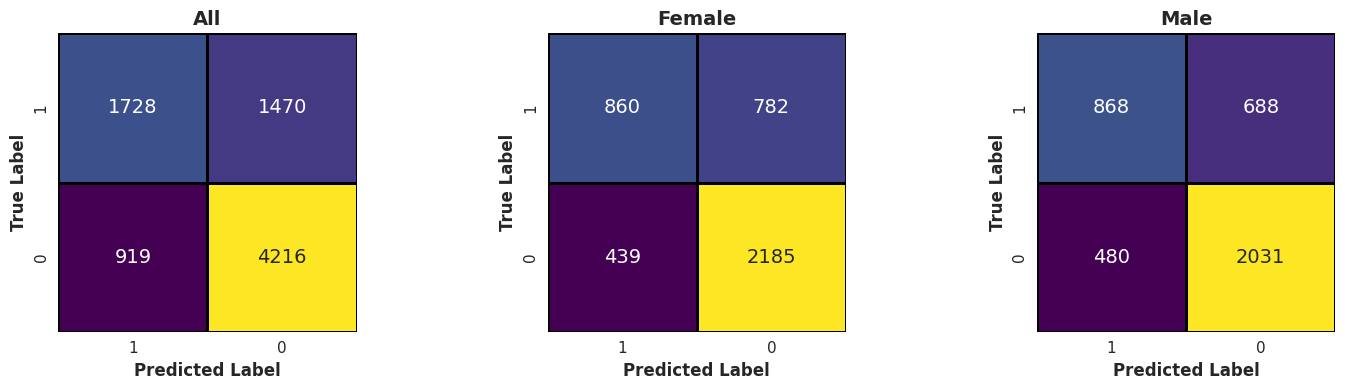

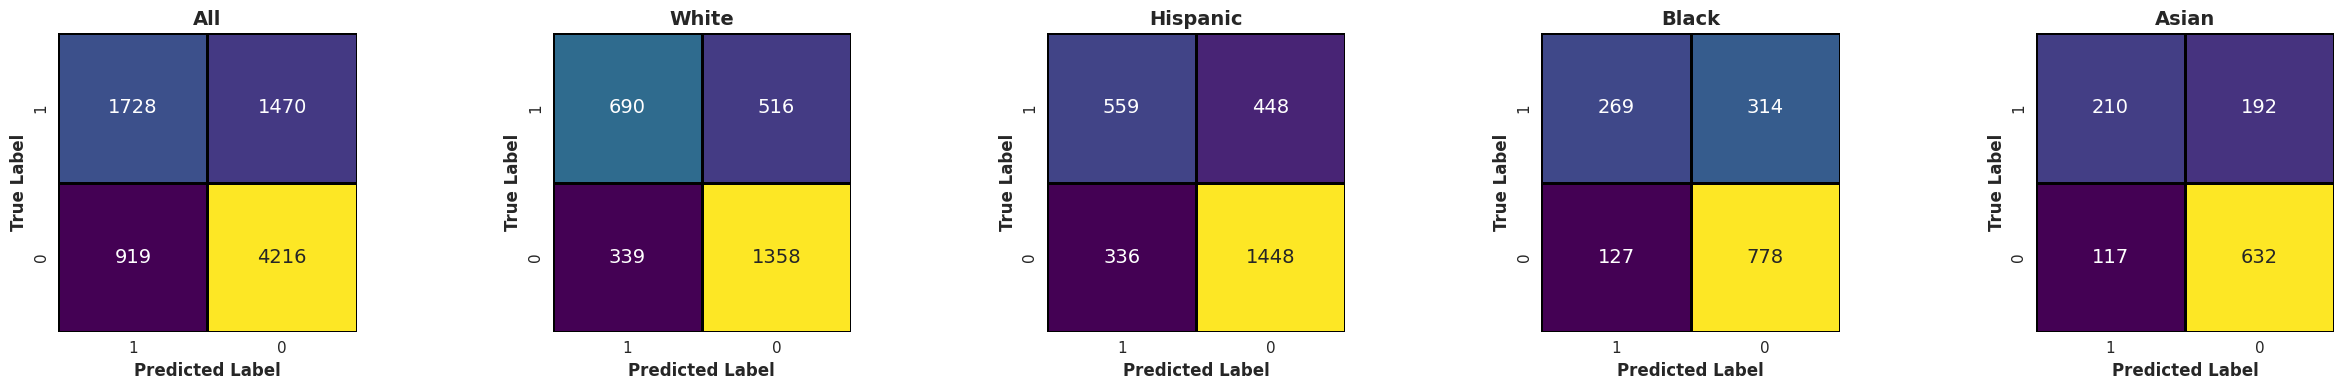

In [ ]:
# Plot for Gender
cms_gender = plot_confusion_matrices(
    groups=data["Gender"].unique(),
    data_test=data_test,
    category="Gender",
    y_test=y_test,
    y_pred_test=y_pred_test
)

# Plot for Ethnicity
cms_ethnicity = plot_confusion_matrices(
    groups=data["Ethnicity"].unique(),
    data_test=data_test,
    category="Ethnicity",
    y_test=y_test,
    y_pred_test=y_pred_test
)


### **5.2 Evaluate True Positive Rate and Equal Opporutinity Difference**

***True Positive Rate (TPR)***. The proportion of actual positive cases correctly predicted by the model within each group. It is calculated as:

$$
TPR_{g} = \frac{TP}{TP + FN}
$$

where:  
- $TP$ is the number of true positives in group $g$.  
- $FN$ is the number of false negatives in group $g$.  



***Equal Opportunity Difference***. The difference in TPR between two groups. It is calculated as:

$$
EOD = TPR_{a} - TPR_{b}
$$

A value between -0.1 and 0.1 is generally considered fair, with stricter bounds of -0.05 and 0.05 used in some contexts.

--- True Positive Rate (TPR) ---
Female = 0.524
Male = 0.558
Asian = 0.522
Black = 0.461
Hispanic = 0.555
White = 0.572

--- Equal Opportunity Difference (EOD) ---
Female vs. Male = -0.03
Black vs. White = -0.11
Asian vs. White = -0.05
Hispanic vs. White = -0.02


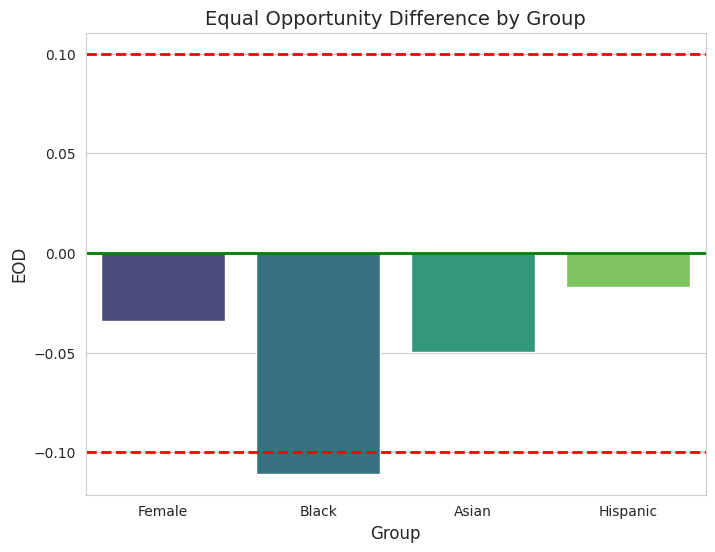

In [ ]:
# Calculate True Positive Rate (TPR) for gender and ethnicity
TPRs_gender = calculate_tpr(cms_gender)
TPRs_ethnicity = calculate_tpr(cms_ethnicity)

print("--- True Positive Rate (TPR) ---")
for g in pred_g_mean.index:
    print(g, '= %.3f' % TPRs_gender[g])
for e in pred_e_mean.index:
    print(e, '= %.3f' % TPRs_ethnicity[e])
print()

# Calculate Equal Opportunity Difference (EOD)
eod_fm = TPRs_gender['Female'] - TPRs_gender['Male']  # Female vs. Male
eod_bw = TPRs_ethnicity['Black'] - TPRs_ethnicity['White']  # Black vs. White
eod_aw = TPRs_ethnicity['Asian'] - TPRs_ethnicity['White']  # Asian vs. White
eod_hw = TPRs_ethnicity['Hispanic'] - TPRs_ethnicity['White']  # Hispanic vs. White

print("--- Equal Opportunity Difference (EOD) ---")
print(f"Female vs. Male = {eod_fm:.2f}")
print(f"Black vs. White = {eod_bw:.2f}")
print(f"Asian vs. White = {eod_aw:.2f}")
print(f"Hispanic vs. White = {eod_hw:.2f}")

eod_data = pd.DataFrame({
    'Group': ['Female', 'Black', 'Asian', 'Hispanic'],
    'EOD': [eod_fm, eod_bw, eod_aw, eod_hw]
})

# Plot Equal Opportunity Difference (EOD)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Group', y='EOD', data=eod_data, palette="viridis", hue='Group', legend=False)
plt.axhline(y=-0.1, linewidth=2, color='r', linestyle="--")  # Threshold for fairness (lower bound)
plt.axhline(y=0.1, linewidth=2, color='r', linestyle="--")   # Threshold for fairness (upper bound)
plt.axhline(y=0, linewidth=2, color='g', linestyle="-")      # Line representing 0 (ideal fairness)
plt.title("Equal Opportunity Difference by Group", fontsize=14)
plt.xlabel("Group", fontsize=12)
plt.ylabel("EOD", fontsize=12)
plt.show()


### **6. Mitigate Bias Against Black Candidates**

In [ ]:
# Include only Black and White candidates for the analysis
data = data[data['Ethnicity'].isin(['Black', 'White'])].copy()

# Split data into training & testing sets
data_train, data_test = train_test_split(data, test_size=0.3, random_state=4)

# Extract features (X), labels (y), and demographics from the split datasets
X_train, y_train, dem_train = split_data_from_df(data_train)
X_test, y_test, dem_test = split_data_from_df(data_test)

# Initialize & Train Ridge Classifier
model = RidgeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set & evaluate accuracy
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)

print(f"Model Accuracy: {accuracy:.2%}")  # Outputs the accuracy in percentage form

data_test = data_test.copy()
data_test["Pred"] = y_pred_test

# Evaluate performance and bias metrics
group_a_test = (dem_test['Ethnicity'] == 'Black')
group_b_test = (dem_test['Ethnicity'] == 'White')
metrics_orig = get_metrics(group_a_test, group_b_test, y_pred_test, y_test)

display(metrics_orig)

Model Accuracy: 70.37%


,Metric,Value,Reference
0,Model Accuracy,0.70,1
1,Black vs. White Disparate Impact,0.77,1
2,Black vs. White Statistical Parity,-0.08,0
3,Black vs. White Average Odds Difference,-0.08,0


#### **6.1 Pre-Processing: Reweighing**

Reweighing (Kamiran and Calders, 2012) is a pre-processing technique that amends the dataset to achieve statistical parity. This method adjusts the weights of the samples in the dataset to compensate for imbalances between different groups. By applying appropriate weights to each instance, it ensures that the model is not biased towards any particular group, thereby promoting fairness. The goal is to adjust the influence of each group so that the final model satisfies fairness criteria such as statistical parity or disparate impact.


In [ ]:
from holisticai.bias.mitigation import Reweighing

# Initialise and fit the Reweighing model to mitigate bias
rew = Reweighing()

# Define the groups (Black and White) in the training data based on the 'Ethnicity' column
group_a_train = (dem_train['Ethnicity'] == 'Black')  # Group A: Black ethnicity
group_b_train = (dem_train['Ethnicity'] == 'White')  # Group B: White ethnicity

# Fit the reweighing technique to adjust sample weights
rew.fit(y_train, group_a_train, group_b_train)

# Extract the calculated sample weights from the reweighing model
sample_weights = rew.estimator_params["sample_weight"]

data_train['sample_weights'] = sample_weights

display(data_train.groupby(['Label', 'Ethnicity'])['sample_weights'].mean())


Label  Ethnicity
0      Black        0.946843
       White        1.027526
1      Black        1.093878
       White        0.960660
Name: sample_weights, dtype: float32

,Metric,Value,Reference
0,Model Accuracy,0.71,1
1,Black vs. White Disparate Impact,0.82,1
2,Black vs. White Statistical Parity,-0.06,0
3,Black vs. White Average Odds Difference,-0.06,0


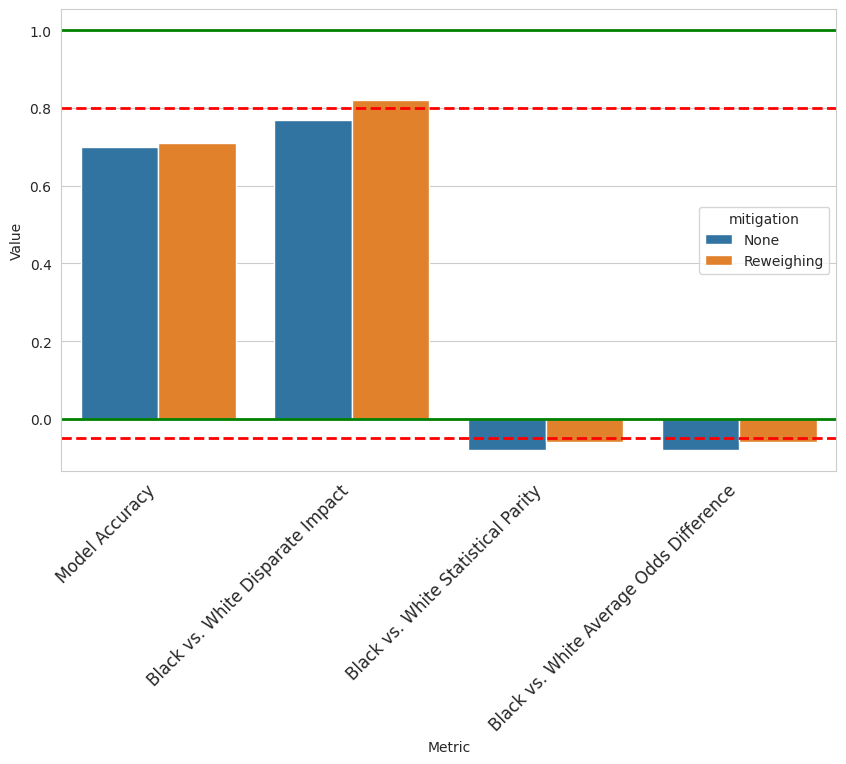

In [ ]:
# Train the model using the sample weights calculated through reweighing
model = RidgeClassifier(random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights.ravel())  # Fit model with sample weights

y_pred_test = model.predict(X_test)

# Define the groupings for fairness analysis (Black and White) in the test set
group_a_test = (dem_test['Ethnicity']=='Black')
group_b_test = (dem_test['Ethnicity']=='White')

# Get the fairness and accuracy metrics after applying reweighing
metrics_rw = get_metrics(group_a_test, group_b_test, y_pred_test, y_test)
display(metrics_rw)

# Add a 'mitigation' column to both metrics dataframes to label them accordingly
metrics_orig['mitigation'] = 'None'
metrics_rw['mitigation'] = 'Reweighing'

metrics = pd.concat([metrics_orig, metrics_rw], axis=0, ignore_index=True)

# Plot the comparison of metrics between the original model and the model with reweighing
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics, x='Metric', y='Value', hue='mitigation')
plt.axhline(y=0.8, linewidth=2, color='r', linestyle="--")
plt.axhline(y=-0.05, linewidth=2, color='r', linestyle="--")
plt.axhline(y=1, linewidth=2, color='g')
plt.axhline(y=0, linewidth=2, color='g')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()


#### **6.2 In-Processing: Grid Search Reduction**

Grid Search Reduction (Agarwal et al., 2018) is an in-processing fairness technique that systematically searches over a predefined set of trade-off parameters to balance accuracy and fairness. It trains multiple models using different weightings of fairness constraints, such as demographic parity or equalized odds, and selects the model that best satisfies the desired fairness-accuracy trade-off. While straightforward to implement, this method can be computationally expensive, especially when searching over a fine-grained grid of parameters. However, it provides a transparent and interpretable way to enforce fairness constraints in classification models.


/home/acelepija/python3.10/lib/python3.10/site-packages/holisticai/bias/mitigation/inprocessing/commons/classification/_constraints.py:175: PerformanceWarning: indexing past lexsort depth may impact performance.
  pos_basis.loc[("+", event_val, group), i] = 1
/home/acelepija/python3.10/lib/python3.10/site-packages/holisticai/bias/mitigation/inprocessing/commons/classification/_constraints.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
  neg_basis.loc[("-", event_val, group), i] = 1
/home/acelepija/python3.10/lib/python3.10/site-packages/holisticai/bias/mitigation/inprocessing/commons/classification/_constraints.py:175: PerformanceWarning: indexing past lexsort depth may impact performance.
  pos_basis.loc[("+", event_val, group), i] = 1
/home/acelepija/python3.10/lib/python3.10/site-packages/holisticai/bias/mitigation/inprocessing/commons/classification/_constraints.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
  neg_ba

,Metric,Value,Reference
0,Model Accuracy,0.48,1
1,Black vs. White Disparate Impact,0.99,1
2,Black vs. White Statistical Parity,-0.01,0
3,Black vs. White Average Odds Difference,0.00,0


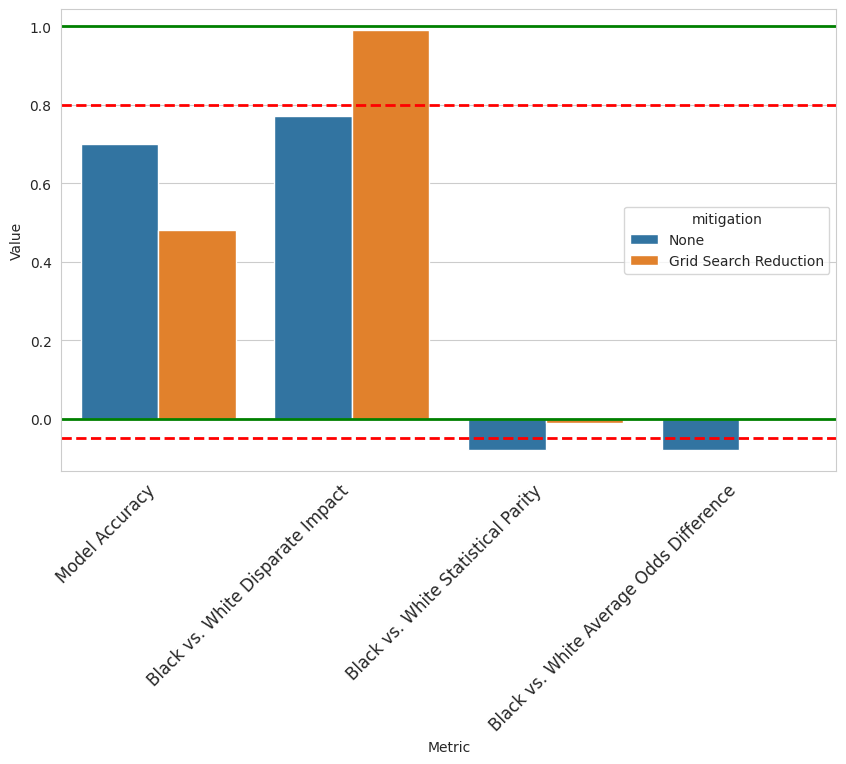

In [ ]:
from holisticai.bias.mitigation import GridSearchReduction

# Train the model using Grid Search Reduction (GSR) bias mitigation technique
model = RidgeClassifier(random_state=42)

gsr = GridSearchReduction()
gsr.transform_estimator(model)

# Define the groupings for fairness analysis (Black and White) in the training set
group_a_train = (dem_train['Ethnicity'] == 'Black')  # Define Black group in training set
group_b_train = (dem_train['Ethnicity'] == 'White')  # Define White group in training set

# Fit GSR with the training data, labels, and group membership
gsr.fit(X_train, y_train, group_a_train, group_b_train)

y_pred_test = gsr.predict(X_test)

# Define groupings for fairness analysis in the test set (Black and White)
group_a_test = (dem_test['Ethnicity'] == 'Black')  # Define Black group in test set
group_b_test = (dem_test['Ethnicity'] == 'White')  # Define White group in test set

# Evaluate the fairness and accuracy metrics for the model with GSR mitigation applied
metrics_gsr = get_metrics(group_a_test, group_b_test, y_pred_test, y_test)  # Get metrics after gsr

display(metrics_gsr)

metrics_orig['mitigation'] = 'None'  # Label for the original model (no mitigation)
metrics_gsr['mitigation'] = 'Grid Search Reduction'  # Label for the GSR model

metrics = pd.concat([metrics_orig, metrics_gsr], axis=0, ignore_index=True)

# Plot the comparison of metrics between the original model and the model with Grid Search Reduction
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics, x='Metric', y='Value', hue='mitigation')
plt.axhline(y=0.8, linewidth=2, color='r', linestyle="--")
plt.axhline(y=-0.05, linewidth=2, color='r', linestyle="--")
plt.axhline(y=1, linewidth=2, color='g')
plt.axhline(y=0, linewidth=2, color='g')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

#### **6.3 Post-Processing: Equalized Odds**

Equalized Odds (Hardt et al., 2016) is a post-processing fairness technique that adjusts the model's predictions after training to ensure fairness across different groups. It aims to equalize the true positive rate (TPR) and false positive rate (FPR) between groups. By modifying the decision thresholds for different groups, Equalized Odds ensures that the model’s performance is equally favorable for all groups, regardless of their demographic characteristics. This method helps to correct any disparities in prediction outcomes that may have arisen during the training phase.


In [ ]:
# Training a model and then treating it like a 'black-box'

# Split Data into Training and Testing Sets
data_train, data_test = train_test_split(data, test_size=0.3, random_state=4)  # Split into train/test sets
X_train, y_train, dem_train = split_data_from_df(data_train)  # Extract features, labels, and demographics for the training set
X_test, y_test, dem_test = split_data_from_df(data_test)  # Extract features, labels, and demographics for the test set

# Initialize and Train Model
model = RidgeClassifier(random_state=42)  # Initialize the RidgeClassifier model with a fixed random seed
model.fit(X_train, y_train)  # Train the model using the training features and labels

y_pred_test = model.predict(X_test)




,Metric,Value,Reference
0,Model Accuracy,0.68,1
1,Black vs. White Disparate Impact,1.35,1
2,Black vs. White Statistical Parity,0.09,0
3,Black vs. White Average Odds Difference,0.09,0


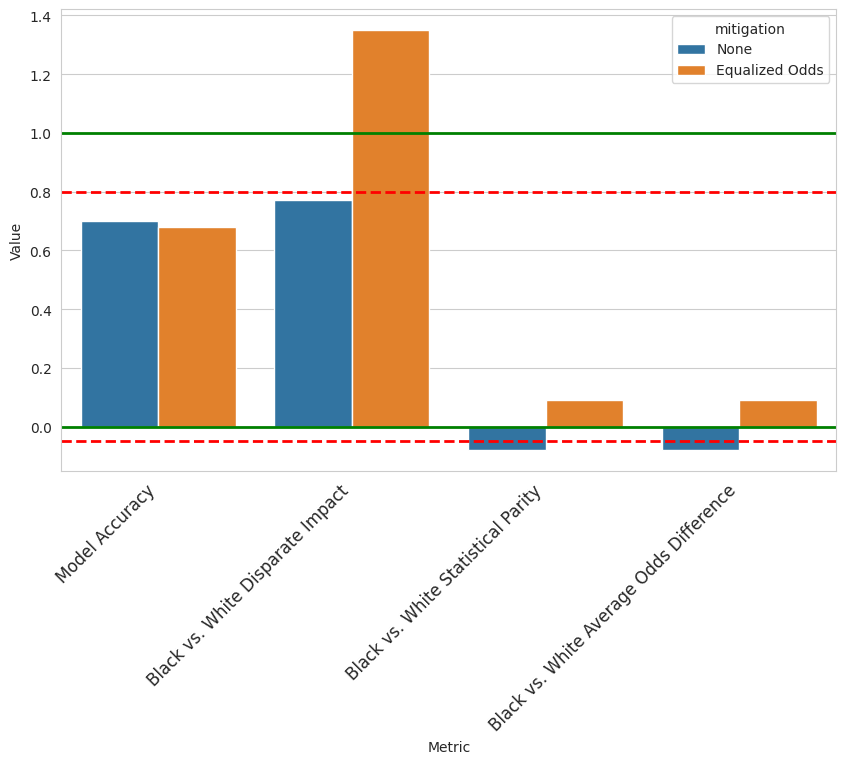

In [ ]:
from holisticai.bias.mitigation import EqualizedOdds
# Split Testing set to have a post-processor 'Training'
data_pp_train, data_pp_test = train_test_split(data_test,test_size = 0.4,random_state=42)
X_pp_train,y_pp_train,dem_pp_train = split_data_from_df(data_pp_train)
X_pp_test,y_pp_test,dem_pp_test = split_data_from_df(data_pp_test)

group_a_pp_train = (dem_pp_train['Ethnicity']=='Black')
group_b_pp_train = (dem_pp_train['Ethnicity']=='White')
group_a_pp_test = (dem_pp_test['Ethnicity']=='Black')
group_b_pp_test = (dem_pp_test['Ethnicity']=='White')

# Fit processor on the 'training' data
eq = EqualizedOdds(solver='highs', seed=42)
fit_params = {
    "group_a": group_a_pp_train,
    "group_b": group_b_pp_train,
}
y_pred_pp_train = model.predict(X_pp_train)

eq.fit(y_pp_train, y_pred_pp_train, **fit_params)

# Apply Processor to Predictions from 'Test' Data
fit_params = {
    "group_a": group_a_pp_test,  # Define the first group (e.g., 'Black' candidates)
    "group_b": group_b_pp_test,  # Define the second group (e.g., 'White' candidates)
}

y_pred_pp_test = model.predict(X_pp_test)  # Predict the labels for the test set

d = eq.transform(y_pred_pp_test, **fit_params)  # Apply equalized odds processor to the predictions

# Extract the new predictions after applying the fairness processor
y_pred_pp_new = d['y_pred']

# Evaluate and Plot Metrics
metrics_eq = get_metrics(group_a_pp_test, group_b_pp_test, y_pred_pp_new, y_pp_test)  # Get fairness metrics
display(metrics_eq)  # Display the fairness metrics

metrics_orig['mitigation'] = 'None'
metrics_eq['mitigation'] = 'Equalized Odds'
metrics = pd.concat([metrics_orig, metrics_eq], axis=0, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics, x='Metric', y='Value', hue='mitigation')
plt.axhline(y=0.8, linewidth=2, color='r', linestyle="--")
plt.axhline(y=-0.05, linewidth=2, color='r', linestyle="--")
plt.axhline(y=1, linewidth=2, color='g')
plt.axhline(y=0, linewidth=2, color='g')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

### **7. Using Explainability Techniques to Explore Bias**

In [ ]:
# Download data, drop NaN values, and filter the dataset to only include 'Black' or 'White' candidates
def split_data_from_df(data):
    # Extract features (X), labels (y), and demographics (dem)
    y = data['Label'].copy()
    X = data[[str(i) for i in np.arange(50) if str(i) in data.columns]].copy()  # Select columns 0-49 for features
    dem = data[['Ethnicity', 'Gender']].copy()  # Demographics: 'Ethnicity' and 'Gender'
    return X, y, dem

# Fetch the dataset from OpenML
bunch = fetch_openml(data_id=44270)

# Load the dataframe, drop rows with NaN values, and filter for only 'Black' and 'White' candidates
df = bunch['frame'].dropna().copy()  # Remove rows with NaN values
df = df[df['Ethnicity'].isin(['Black', 'White'])].reset_index(drop=True).copy()  # Filter by 'Black' or 'White' ethnicity

# Display the first few rows of the cleaned dataset
df.head()

,Label,Gender,Ethnicity,0,1,2,3,4,5,6,...,40,41,42,43,44,45,46,47,48,49
0,1,Female,Black,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,...,0.513206,-0.042387,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617
1,0,Male,Black,0.152488,-0.731821,-0.167126,-1.193398,1.180502,0.469656,-0.044317,...,-0.483960,-1.292245,-0.298833,2.067846,0.304233,-0.160228,1.017770,-1.002570,0.844326,-1.155311
2,0,Female,Black,0.055918,-0.291155,-0.787822,-0.777313,1.304448,0.522195,-1.581933,...,0.015100,-0.140562,-2.259381,1.270556,0.150888,0.525393,-0.660325,0.531138,0.814141,-1.269334
3,0,Male,Black,0.698395,-0.312582,0.150934,1.706846,0.080574,0.127306,1.457853,...,-0.165776,-0.423251,0.420080,-0.257311,-0.828977,-0.204993,0.438121,1.175627,-0.684174,0.021289
4,0,Male,Black,-0.525550,1.774030,-0.625130,0.665376,0.217817,0.432447,-0.273375,...,0.160506,0.383675,1.401638,-0.904647,-1.345446,0.131165,0.376871,-0.770790,-0.749922,0.153647


In [ ]:
# Split the data into train and test sets (30% test size)
data = df.copy()  # Create a copy of the original dataset
data_train, data_test = train_test_split(data, test_size=0.3, random_state=3)

# Process the training and test sets into features, labels, and demographics
X_train, y_train, dem_train = split_data_from_df(data_train)
X_test, y_test, dem_test = split_data_from_df(data_test)

# Define and train the model (LightGBM Classifier)
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Compute accuracy and disparate impact on the test set predictions
group_a_test = (dem_test['Ethnicity'] == 'Black')  # Define group A (Black ethnicity)
group_b_test = (dem_test['Ethnicity'] == 'White')  # Define group B (White ethnicity)
acc_base = accuracy_score(y_pred_test, y_test)  # Calculate accuracy
di_base = disparate_impact(group_a_test, group_b_test, y_pred_test)  # Calculate disparate impact

# Print the results
print("Accuracy = %.2f" % acc_base)
print("Disparate impact = %.2f" % di_base)


[LightGBM] [Info] Number of positive: 1268, number of negative: 2021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 3289, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385528 -> initscore=-0.466152
[LightGBM] [Info] Start training from score -0.466152
Accuracy = 0.69
Disparate impact = 0.75


#### **7.1 Permutation Feature Importance**  

Permutation Feature Importance is a model-agnostic technique used to measure the impact of each feature on a model’s predictions. Unlike model-specific methods, it works by assessing how shuffling a feature affects the model’s error.

In linear regression, feature importance can be computed as the product of the feature value and its corresponding weight. However, for more complex or non-linear models, alternative approaches like *Permutation Feature Importance* are necessary.  

Given:  
- $X$ as the feature matrix (where each row $i$ represents a sample and each column $j$ represents a feature).  
- $e$ as the model's prediction error when using $X$.  

The feature importance of feature $j$ is determined as follows:  
1. Create a new feature matrix $X_j$ by randomly permuting column $j$.  
2. Compute the new model error $e_j$ using $X_j$.  
3. Define the feature importance as:  

$$
FI_j = e_j - e
$$

In essence, this method evaluates the importance of a feature by randomly shuffling its values and observing how much the model's error changes.


In [ ]:
# Function to permute a specific feature column in the dataset
def permute_X(X, j):
    Xj = X.copy()
    Xj[j] = Xj[j].sample(frac=1).values  # Shuffle feature values
    return Xj

# Define parameters
np.random.seed(10)
n_features = 50
n_iter = 10

# Initialize arrays to store accuracy and disparate impact results
accs = np.zeros((n_iter, n_features))
dis = np.zeros((n_iter, n_features))

# Iterate over features and perform permutation testing
for j in tqdm(range(n_features)):
    for i in range(n_iter):
        # Shuffle feature j and make predictions
        X_test_permuted = permute_X(X_test, str(j))
        y_pred_test_permuted = model.predict(X_test_permuted)

        # Compute accuracy and disparate impact and store results
        accs[i, j] = accuracy_score(y_test, y_pred_test_permuted)
        dis[i, j] = disparate_impact(group_a_test, group_b_test, y_pred_test_permuted)


  0%|          | 0/50 [00:00<?, ?it/s]

#### **7.2 Feature Importance Impact on Accuracy**  

<Axes: xlabel='feature', ylabel='imp_mean'>

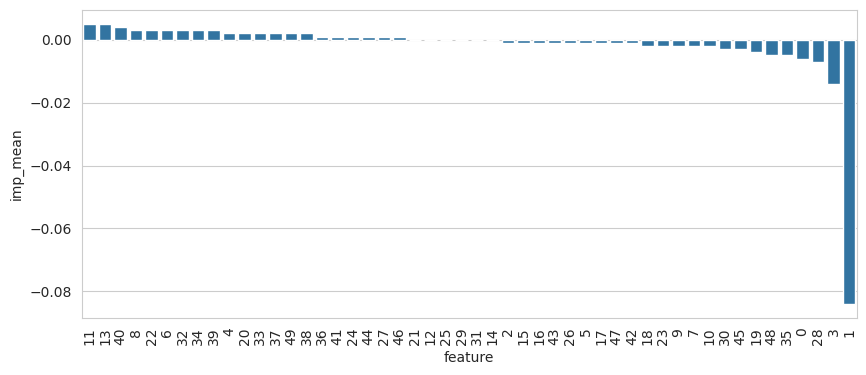

In [ ]:
# Compute the change in accuracy and disparity when permuting each feature
accs_diff = accs - acc_base
dis_diff = dis - di_base

# Compute mean and standard deviation of accuracy differences across runs
means = accs_diff.mean(axis=0)
stds = accs_diff.std(axis=0)

# Create a DataFrame to store feature importance results
df_imp = pd.DataFrame(np.arange(50), columns=['feature'])
df_imp['feature'] = df_imp['feature'].astype(str)
df_imp['imp_mean'] = means.round(3)
df_imp['imp_std'] = stds.round(3)

# Sort features by importance (descending order) and reset index
df_imp = df_imp.sort_values(by='imp_mean', ascending=False).reset_index(drop=True)

# Create a bar plot to visualize feature importance
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.xticks(rotation=90)
sns.barplot(data=df_imp, y='imp_mean', x='feature', ax=ax)


#### **7.3 Feature Importance Impact on Bias**  

<Axes: xlabel='feature', ylabel='imp_mean'>

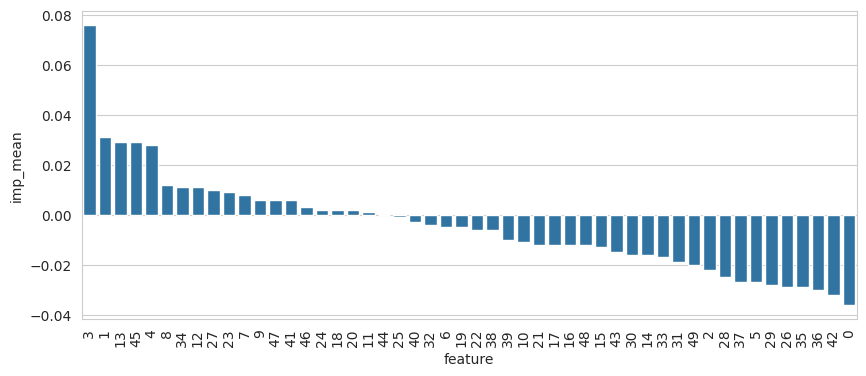

In [ ]:
# Compute the mean and standard deviation of disparate impact differences per feature
means = dis_diff.mean(axis=0)
stds = dis_diff.std(axis=0)

# Create a DataFrame to store feature importance based on disparity impact
df_imp = pd.DataFrame(np.arange(50), columns=['feature'])
df_imp['feature'] = df_imp['feature'].astype(str)
df_imp['imp_mean'] = means.round(3)
df_imp['imp_std'] = stds.round(3)

# Sort features by importance
df_imp = df_imp.sort_values(by='imp_mean', ascending=False).reset_index(drop=True)

# Create a bar plot to visualize feature importance based on disparity impact
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.xticks(rotation=90)
sns.barplot(data=df_imp, y='imp_mean', x='feature', ax=ax)


#### **7.4 Retrain Model Without Feature 3**  

In [ ]:
# Define the model (LightGBM Classifier)
model = LGBMClassifier(random_state=42)

# Split data into train/test (30% test size)
data_train, data_test = train_test_split(data, test_size=0.3, random_state=3)

# Drop unnecessary column (assumed to be '3'), then split the train/test data into features, labels, and demographics
data_train = data_train.drop(columns=['3']).copy()
data_test = data_test.drop(columns=['3']).copy()
X_train, y_train, dem_train = split_data_from_df(data_train)
X_test, y_test, dem_test = split_data_from_df(data_test)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Get accuracy and disparate impact for the test set predictions
group_a_test = (dem_test['Ethnicity'] == 'Black')  # Define group A (Black ethnicity)
group_b_test = (dem_test['Ethnicity'] == 'White')  # Define group B (White ethnicity)
acc = accuracy_score(y_pred_test, y_test)  # Calculate accuracy
di = disparate_impact(group_a_test, group_b_test, y_pred_test)  # Calculate disparate impact

print("Accuracy = %.2f" % acc)
print("Disparate Impact = %.2f" % di)

Accuracy = 0.68
Disparate Impact = 0.83
